# Crosstalk Analysis
The goal of this notebook is to quantify the effect of wavelength crosstalk in passage

In [1]:
import matplotlib.pyplot as plt
plt.style.use("asludds")
import numpy as np
from scipy.constants import c
from lmphoton.simulation import current_simulation as sim
from lmtimesim.components.Filters.crr_array_configurable_num_crrs import Congo_CRR_Array
# from lmtimesim.components.Filters.local_sim_comps.crr import CongoCRR

data_rate = 56e9

crr_array = Congo_CRR_Array()
crr_array._rc_filter_bool = False
for i in range(8):
    crr_array.crrs[i]._rc_filter_bool = False

def raised_cosine(frequency_sweep,T,beta):
    returnable = []
    for f in frequency_sweep:
        if np.abs(f) < (1-beta)/(2*T):
            returnable.append(1)
        elif ((1-beta)/(2*T) < np.abs(f)) and (np.abs(f) < (1+beta)/(2*T)):
            returnable.append(0.5 * (1 + np.cos(np.pi *T /beta * (np.abs(f) - (1-beta)/(2*T)))))
        else:
            returnable.append(0)
    return np.array(returnable)

# Applying the raised cosine filter to data:
# rc = raised_cosine(freqs[idx],1/data_rate,beta=0.28)

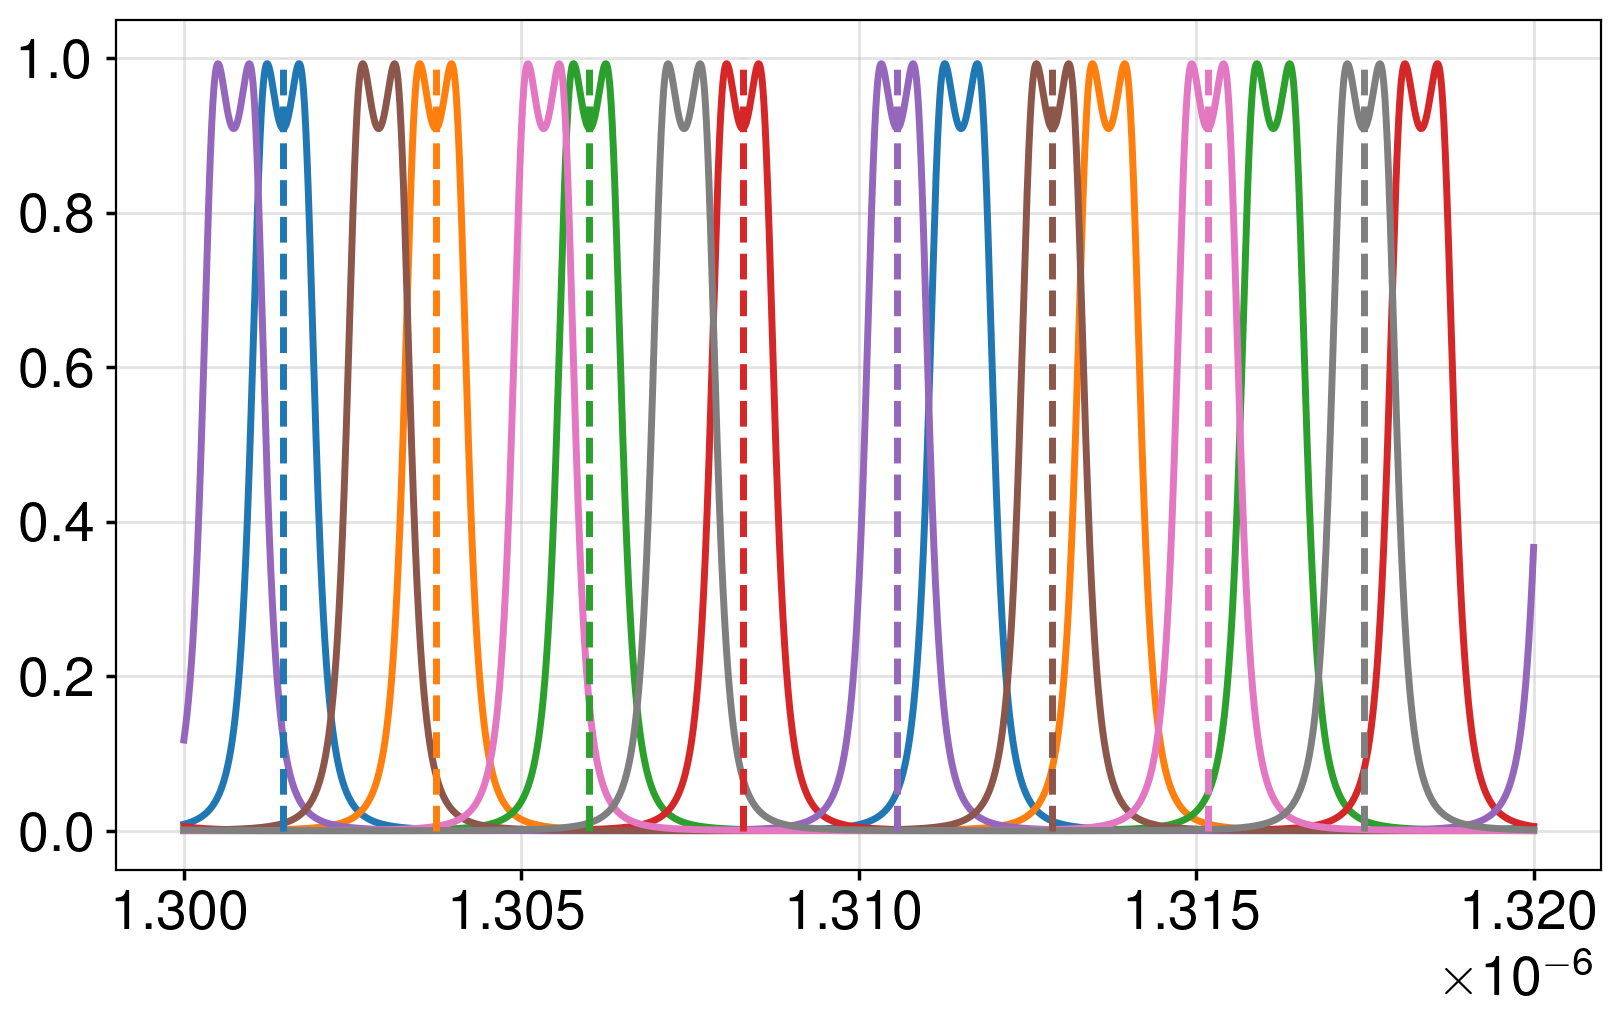

In [2]:
# Setup the CRR array in nominal conditions
CLM_laser_wavelengths = [
    1301.47*1e-9,
    1303.73*1e-9,
    1306.01*1e-9,
    1308.28*1e-9,
    1310.57*1e-9,
    1312.87*1e-9,
    1315.17*1e-9,
    1317.48*1e-9,
]

def lock_crr(crr_ref,laser_wavelength):
    voltage_sweep = np.linspace(0,2,num=5000)
    sim().wavelength = laser_wavelength
    drop_port_storage = []
    residual_phase_storage = []
    for _, v in enumerate(voltage_sweep):
        crr_ref.top_ring_heater_voltage = v
        crr_ref.bottom_ring_heater_voltage = v
        residual_phase = np.real(crr_ref.ps1.complex_phase) % (2*np.pi)
        residual_phase_storage.append(residual_phase)
        drop_port_storage.append(crr_ref.drop_port_transmission())
    drop_port_storage  = np.array(drop_port_storage)

    for i in range(10):
        crr_ref.top_ring_heater_voltage = voltage_sweep[np.argmin(residual_phase_storage)]
        crr_ref.bottom_ring_heater_voltage = voltage_sweep[np.argmin(residual_phase_storage)]
    return voltage_sweep[np.argmin(residual_phase_storage)]

# Lock a CRR to a laser
crr_lock_voltages = []
for index in range(len(crr_array.crrs)):
    crr_lock_voltages.append(lock_crr(crr_array.crrs[index],CLM_laser_wavelengths[index]))
crr_lock_voltages = np.array(crr_lock_voltages)

for i in range(10):
    crr_array.top_heater_voltages = crr_lock_voltages
    crr_array.bottom_heater_voltages = crr_lock_voltages

wavelength_sweep = np.linspace(1300e-9,1320e-9,num=int(1e4))
crr_storage = []
for crr in crr_array.crrs:
    crr_transmission = []
    for wl in wavelength_sweep:
        sim().wavelength = wl
        crr.drop_port_transmission()
        crr_transmission.append(crr.drop_port_transmission())
    crr_storage.append(np.array(crr_transmission))

plt.figure()
for i in range(8):
    plt.plot(wavelength_sweep,crr_storage[i],color=f'C{i}')
for wavindex,wav in enumerate(CLM_laser_wavelengths):
    plt.vlines(wav,ymin=0,ymax=1,linestyle='--',color=f'C{wavindex}')
plt.show()

In [3]:
sim().wavelength = CLM_laser_wavelengths[0]
crr_array.recursive_update()
print(crr_array.crrs[0].top_ring_heater_voltage)
print(crr_array.crrs[0].ps1.waveguide_temperature)
print(np.real(crr_array.crrs[0].ps1.complex_phase) % (2*np.pi))
# print(np.real(crr_array.crrs[0].ps1.complex_phase) % (2*np.pi))

1.4866973394678935
614.7819664327512
0.0006622098712583124


In [4]:
def generate_data_spectrum(wav_sweep,center_wav):
    sequence_length = int(1e6)
    data_rate = 56e9
    wavelength_to_frequency = c/(center_wav**2)*(wav_sweep - center_wav)
    # print(wavelength_to_frequency)
    ideal_sinc = sequence_length * data_rate * np.array([1/data_rate * np.sin(np.pi * f /data_rate)**2/(np.pi * f / data_rate)**2 for f in wavelength_to_frequency])
    ideal_sinc /= np.max(ideal_sinc)
    return ideal_sinc

ideal_sinc = generate_data_spectrum(wavelength_drop_port_V0p5*1e-9,1308.17e-9)



plt.figure()
plt.plot(wavelength_drop_port_V0p5,10*np.log10(ideal_sinc),zorder=101)
# plt.ylim(30,100)
plt.xlabel("Offset from carrier frequency (GHz)")
plt.ylabel("Normalized Power (dB)")
plt.title("Optical Spectrum with Data")
plt.show()

NameError: name 'wavelength_drop_port_V0p5' is not defined